In [1]:
import matplotlib.pyplot as plt
import pickle, os, sys
from XANES2020_code.Espec import espec_processing 
from XANES2020_code import mirage_analysis
from XANES2020_code.general_tools import imagesc, load_object
from XANES2020_code.Betatron_analysis import xray_analysis as xray
from XANES2020_code.Betatron_analysis.beam_fitting import GP_beam_fitter
# you need to set this to the path to your data folder 
# which should have the same strucutre as on the Box for everything to work
BASE_PATH =r'/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/'
mirage_analysis.configure(BASE_PATH)


# Electron spectrometer analysis

In [2]:
# paths for image warp and dispersion calibrations files
tForm_filepath = 'XANES2020_code/Espec/Espec_high_transform_20200829.pkl'
Espec_cal_filepath = 'XANES2020_code/Espec/Espec_high_disp_cal_20200829.mat'
# Setup analysis object which stores the relavant meta data and contains functions to run on the espec files
eSpec_proc = espec_processing.ESpec_high_proc(tForm_filepath,Espec_cal_filepath,
                             img_bkg=None,use_median=True,kernel_size=None )


## Using mirage pipelines to analysis whole runs in one go

In [3]:
# I'm using the package Stephen wrote to handle the file paths and everything
# I've slightly modified it to work for single shot mode (which is what we are mostly using) 
# The first argument is the diagnostic name, the second is the function to run on the raw data
# The third argument is how to handle bursts (not used for single shot mode)
# The actual file opening is handled using functions defined in mirage_analysis.loader and is
#  specified per diagnostic in the mirage.__init__.py file 
#  e.g. 
#  register_data_loader('ESpec_high', ImageDataLoader)
#  where the first argument is diagnostic name 
#  and the second is the function that takes a file path and returns the raw data
espec_pC_pipeline = mirage_analysis.DataPipeline('ESpec_high', 
                                                  eSpec_proc.total_charge, None,
                                                  single_shot_mode=True)

espec_W_b_pipeline = mirage_analysis.DataPipeline('ESpec_high', 
                                                  eSpec_proc.total_beam_energy, None,
                                                  single_shot_mode=True)


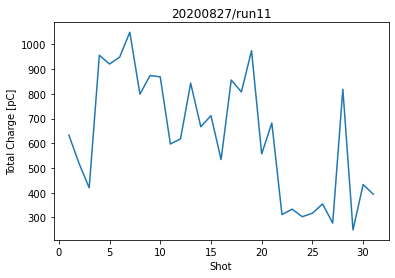

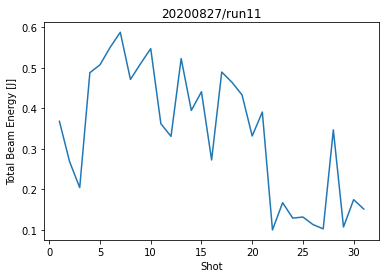

In [4]:
# the pipelines are run on a particular data run as shown below

run_name = r'20200827/run09'
run_name = r'20200827/run11'
# run_name = r'20200827/run12'
# run_name = r'20200903/run01'
# run_name = r'20200903/run04'
shot_num, espec_pC = espec_pC_pipeline.run(run_name,use_pandas=False)


plt.figure()
plt.plot(shot_num,espec_pC)
plt.xlabel('Shot')
plt.ylabel('Total Charge [pC]')
plt.title(run_name)
plt.savefig(r'plots/ESpec_high/' + run_name.replace(r'/','_') + '_total_charge.png')

shot_num, espec_pC = espec_W_b_pipeline.run(run_name,use_pandas=False)
plt.figure()
plt.plot(shot_num,espec_pC)
plt.xlabel('Shot')
plt.ylabel('Total Beam Energy [J]')
plt.title(run_name)
plt.savefig(r'plots/ESpec_high/' + run_name.replace(r'/','_') + '_total_beam_energy.png')

## Analyse individual shots
You don't have to use mirage, you can use the analysis function on individual shots with your own code

In [5]:
# convert particular file into a spectrum
img_raw = plt.imread(os.path.join(BASE_PATH,r'Espec_high/20200827/run12/Shot007.tif'))
img_pC_permm2 = eSpec_proc.espec_data2screen(img_raw)
spec_pC_per_mm_per_MeV = eSpec_proc.espec_screen2spec(img_pC_permm2)                 



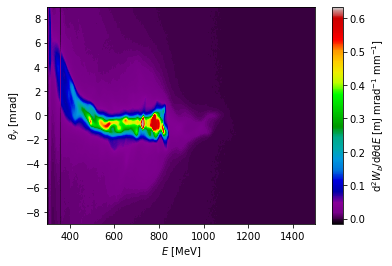

In [6]:
# display the energy per MeV per mrad
plt.figure()
ax = plt.axes()
screen_dist_m = 1.48
y_mrad = (eSpec_proc.screen_y_mm-38)/screen_dist_m
spec_mJ_per_mrad_per_MeV = spec_pC_per_mm_per_MeV*eSpec_proc.eAxis_MeV*screen_dist_m*1e-3
ih = imagesc(spec_mJ_per_mrad_per_MeV,
             x=eSpec_proc.eAxis_MeV,y=y_mrad,
             ax=ax,cmap='nipy_spectral',vmax=None)
plt.xlabel(r'$E$ [MeV]')
plt.ylabel(r'$\theta_y$ [mrad]')
plt.ylim((-9,9))

cb = plt.colorbar(ih,ax=ax)
cb.set_label(r'd$^2W_b$/d$\theta$d$E$ [mJ mrad$^{-1}$ mm$^{-1}$]')

# Lundatron

## Kris' code

In [2]:
from XANES2020_code.rossFilterAnalysis import rossMain
import matplotlib.pyplot as plt
from PIL import Image


### Try a single shot

2454.5454545454545
80431000.82924697
0.050468027702204724


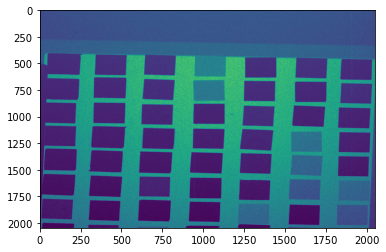

In [3]:
file_path = '/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/Lundatron/20200827/run09/Shot004.tif'
raw = Image.open(file_path)

critical_energy, photonperSteradian, min_sumResid = rossMain.rossMain(raw)

print(critical_energy)
print(photonperSteradian)
print(min_sumResid)
imagesc(raw)
# lundatron_pipeline = mirage_analysis.DataPipeline('ESpec_high', 
#                                                   eSpec_proc.total_charge, None,
#                                                   single_shot_mode=True)

### Pipeline

In [4]:
def Ec_func(data):
    img_raw = Image.fromarray(data)
    critical_energy, photonperSteradian, min_sumResid = rossMain.rossMain(img_raw)
    
    return critical_energy

lundatron_pipeline = mirage_analysis.DataPipeline('Lundatron', 
                                                  Ec_func, None,
                                                  single_shot_mode=True)
    

(1327.2727272727273, 26127.272727272728)

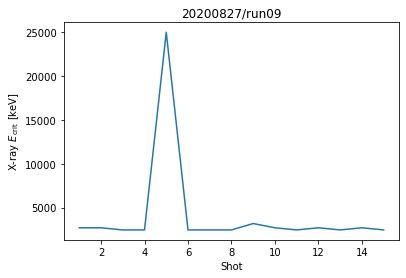

In [5]:
run_name = r'20200827/run09'
shot_num, E_crit = lundatron_pipeline.run(run_name,use_pandas=False)
plt.figure()
plt.plot(shot_num,E_crit)
plt.xlabel('Shot')
plt.ylabel('X-ray $E_{\mathrm{crit}}$ [keV]')
plt.title(run_name)
plt.savefig(r'plots/ESpec_high/' + run_name.replace(r'/','_') + '_Lundatron_Ec.png')
plt.ylim()

## Matt's code

In [2]:
from PIL import Image
from scipy.ndimage.filters import median_filter
from skimage.io import imread
def load_lundatron(file_path):
    return np.array(Image.open(file_path)).astype(float)

def lundatron_file2signal(file_path,bkg):
    img_raw = load_lundatron(img_file)  
    img_sub = img_raw -bkg
    return median_filter(img_sub,(3, 3))

### Single shot

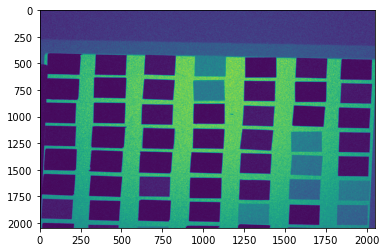

In [55]:
bkg_file = '/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/Lundatron/20200827/run05/Shot001.tif'
run_name = '20200827/run09'
shot_num = 4
shot_file = os.path.join(run_name,f'Shot{shot_num:03}.tif')
img_file = os.path.join(BASE_PATH,'Lundatron/',shot_file)


img_bkg = load_lundatron(bkg_file)
img_sub = lundatron_file2signal(img_file,img_bkg)

imagesc(img_sub)

In [56]:
XRAY_CODE_PATH = r'XANES2020_code/Betatron_analysis'
xrayPath = os.path.join(os.getcwd(),XRAY_CODE_PATH)
if xrayPath not in sys.path:
    sys.path.append(xrayPath)
    
mask_filepath = os.path.join(XRAY_CODE_PATH,r'filter_masks/20200827_run09_Lundatron_filter_masks.pkl')

mask_obj=load_object(mask_filepath)
run_name_pref = '20200827_run09'
filter_filepath = file_path = os.path.join(XRAY_CODE_PATH,r'transmission_functions/' +  run_name_pref +'_Lundatron_filter_pack.pkl')

filter_obj = load_object(filter_filepath)
BF = GP_beam_fitter(mask_obj['beam_mask'],N_samples = 1000)
img_sub = img_sub - np.mean(img_sub[mask_obj['filter_number_regions']>=20])
    

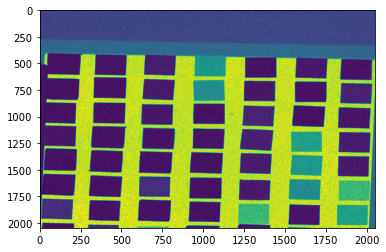

In [57]:
beam_estimate,beam_uncertainty = BF.fit_beam(img_sub,med_filter=None)
transmission_img = img_sub/beam_estimate
imagesc(transmission_img,vmax=1.1)

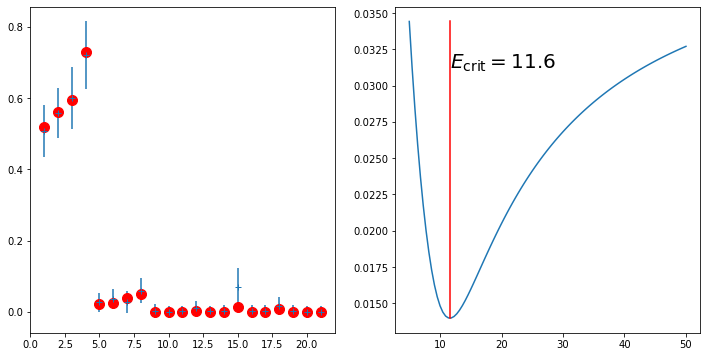

In [58]:

B_fitter = xray.Betatron_spec_fitter(transmission_img,filter_obj,mask_obj)

Ec_opt, trans_pred = B_fitter.calc_E_crit()
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].errorbar(B_fitter.filter_number,B_fitter.measured_trans,B_fitter.measured_trans_rms,
               fmt='+')
axs[0].plot(B_fitter.filter_number, trans_pred ,'ro',ms=10)
       
Ec_array = np.linspace(5,50,num=100)
trans_err = []
for Ec in Ec_array:
    trans_err.append(B_fitter.err_func(Ec))
axs[1].plot(Ec_array,trans_err)
axs[1].plot((Ec_opt,Ec_opt),(np.min(trans_err),np.max(trans_err)),'r-')
axs[1].text(Ec_opt,np.min(trans_err)+np.max(trans_err)/2,
            r'$E_{\mathrm{crit}} = $' + f'{Ec_opt:3.1f}',
            fontdict = {'fontsize':20});

###  Pipeline

In [50]:
def lundatron_img2signal(img_raw,bkg):
    img_sub = img_raw -bkg
    return median_filter(img_sub,(3, 3))

def null_fcn(data):
    return data


def find_ecrit(data):

    mask_obj=load_object(mask_filepath)
    filter_obj = load_object(filter_filepath)
    img_sub = lundatron_img2signal(data,img_bkg)
    img_sub = img_sub - np.mean(img_sub[mask_obj['filter_number_regions']>=20])
    
    BF = GP_beam_fitter(mask_obj['beam_mask'],N_samples = 1000)
    
    beam_estimate,beam_uncertainty = BF.fit_beam(img_sub,med_filter=None)
    transmission_img = img_sub/beam_estimate
    
    B_fitter = xray.Betatron_spec_fitter(transmission_img,filter_obj,mask_obj)
    B_fitter.measure_transmission()
#     B_fitter.measured_trans = B_fitter.measured_trans-np.min(B_fitter.measured_trans)
    Ec_opt, trans_pred = B_fitter.calc_E_crit()
    return Ec_opt


lundatron_pipeline_matt = mirage_analysis.DataPipeline('Lundatron', 
                                                  find_ecrit, None,
                                                  single_shot_mode=True)
    

In [51]:
run_name = r'20200827/run09'
shot_num, E_crit = lundatron_pipeline_matt.run(run_name,use_pandas=False)


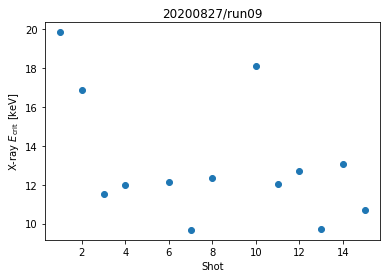

In [54]:
shot_num = np.array(shot_num)
iSel = 1-1.0*(shot_num==5) - 1.0*(shot_num==9)
iSel=iSel>0
plt.figure()
plt.plot(shot_num[iSel],E_crit[iSel],'o')
plt.xlabel('Shot')
plt.ylabel('X-ray $E_{\mathrm{crit}}$ [keV]')
plt.title(run_name)
plt.savefig(r'plots/Lundatron/' + run_name.replace(r'/','_') + '_Lundatron_Ec.png')

